<a href="https://colab.research.google.com/github/MLLSCKR/Paper_Implementation/blob/main/Neural_Style_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Style Transformer

Neural style transfer algorithm works as follows
1. Take a pretrained classification model(ex. VGG19), remove the last layers, and keep the remaining layers to serve as a feature extractor.
2. Feed the content image to the model and get selected features to serve as the target content.
3. Feed the style image to the model and get the Gram matrix of selected features to serve as the target style.
4. Feed the input to the model and get the features and the Gram matrix of selected features to serve as the predicted content and sytle, respectively.
5. Compute the content and style errors, and use this information to update the input and reduce the error.
6. Repeat step4 until the error is minimized.

In [ ]:
# Neural Style Transformer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = "pytorch_practice"
assert FOLDERNAME is not None, "[!] Enter the foldername."

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd /content/drive/My\ Drive/$FOLDERNAME

%cd /content/drive/My\ Drive/pytorch_practice/Chapter8/

Mounted at /content/drive
/content/drive/My Drive/pytorch_practice
/content/drive/My Drive/pytorch_practice/Chapter8


In [ ]:
from PIL import Image
path2content = "./data/content_img.jpg"
path2style = "./data/style_img.jpg"
content_img = Image.open(path2content)
style_img = Image.open(path2style)

In [ ]:
# content image attribute
print("file width: {}".format(content_img.width))
print("file height: {}".format(content_img.height))

file width: 1280
file height: 960


In [ ]:
# content image piexel mean std
import numpy as np
content_array = np.array(content_img)
print(content_array.shape)
print("mean: {}".format(np.mean(content_array, axis = (0, 1))))
print("std: {}".format(np.std(content_array, axis = (0, 1))))

(960, 1280, 3)
mean: [144.64157552 135.09901123 110.14378337]
std: [41.85036461 36.59575983 32.87187125]


In [ ]:
import torchvision.transforms as transforms

h, w = 256, 384
mean_rgb = (0.485, 0.456, 0.406)
std_rgb = (0.229, 0.224, 0.225)

transformer = transforms.Compose([
              transforms.Resize((h, w)),
              transforms.ToTensor(),
              transforms.Normalize(mean_rgb, std_rgb)])

In [ ]:
content_tensor = transformer(content_img)
print(content_tensor.shape, content_tensor.requires_grad)

torch.Size([3, 256, 384]) False


In [ ]:
style_tensor = transformer(style_img)
print(style_tensor.shape, style_tensor.requires_grad)

torch.Size([3, 256, 384]) False


In [ ]:
import torch
import matplotlib.pylab as plt
from torchvision.transforms.functional import to_pil_image

# helper function to convert back tensors to PIL images
def imgtensor2pil(img_tensor):
  img_tensor_c = img_tensor.clone().detach()
  img_tensor_c *= torch.tensor(std_rgb).view(3, 1, 1)
  img_tensor_c += torch.tensor(mean_rgb).view(3, 1, 1)
  img_tensor_c = img_tensor_c.clamp(0, 1)
  img_pil = to_pil_image(img_tensor_c)

  return img_pil

Text(0.5, 1.0, 'content image')

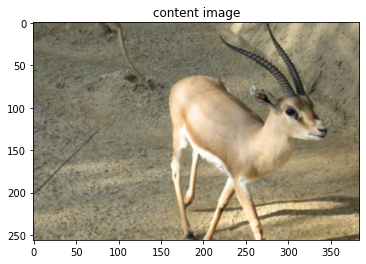

In [ ]:
plt.imshow(imgtensor2pil(content_tensor))
plt.title("content image")

Text(0.5, 1.0, 'style image')

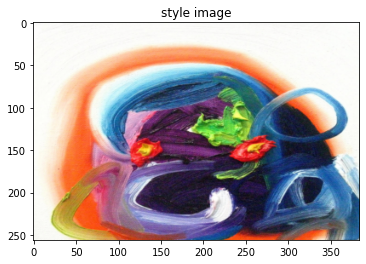

In [ ]:
plt.imshow(imgtensor2pil(style_tensor))
plt.title("style image")

In [ ]:
import torchvision.models as models

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_vgg = models.vgg19(pretrained = True).features.to(device).eval() 
print(model_vgg)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [ ]:
# freeze the model parameters
for param in model_vgg.parameters():
  param.requires_grad_(False)

In [ ]:
import torch.nn.functional as F

# helper function to get the outputs of intermediate layers
def get_features(x, model, layers):
  features = {}
  for name, layer in enumerate(model.children()):
    x = layer(x)
    
    if str(name) in layers: # extract intermediate outputs in layers list
      features[layers[str(name)]] = x
  
  return features

# helper function to compute the Gram matrix of a tensor
def gram_matrix(x):
  n, c, h, w = x.size()
  x = x.view(n*c, h*w)
  gram = torch.mm(x, x.t())
  return gram

# helper function to compute the content loss
def get_content_loss(pred_features, target_features, layer):
  target = target_features[layer]
  pred = pred_features[layer]
  loss = F.mse_loss(pred, target)
  return loss

# helper function to compute the style loss
def get_style_loss(pred_features, target_features, style_layers_dict):
  loss = 0
  for layer in style_layers_dict:
    pred_fea = pred_features[layer]
    pred_gram = gram_matrix(pred_fea)

    n, c, h, w = pred_fea.shape

    target_gram = gram_matrix(target_features[layer])
    layer_loss = style_layers_dict[layer] * F.mse_loss(pred_gram, target_gram)

    loss += layer_loss / (n*c*h*w)
  
  return loss

In [ ]:
for name, layer in enumerate(model_vgg.children()):
  print("name : {}, layer : {}".format(name, layer))

name : 0, layer : Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
name : 1, layer : ReLU(inplace=True)
name : 2, layer : Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
name : 3, layer : ReLU(inplace=True)
name : 4, layer : MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
name : 5, layer : Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
name : 6, layer : ReLU(inplace=True)
name : 7, layer : Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
name : 8, layer : ReLU(inplace=True)
name : 9, layer : MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
name : 10, layer : Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
name : 11, layer : ReLU(inplace=True)
name : 12, layer : Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
name : 13, layer : ReLU(inplace=True)
name : 14, layer : Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding

In [ ]:
feature_layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2',
                  '28': 'conv5_1'}
con_tensor = content_tensor.unsqueeze(0).to(device) # return a new tensor with a dimension of size one
sty_tensor = style_tensor.unsqueeze(0).to(device)

content_features = get_features(con_tensor, model_vgg, feature_layers)
style_features = get_features(sty_tensor, model_vgg, feature_layers)

for key in content_features.keys():
  print(content_features[key].shape)

torch.Size([1, 64, 256, 384])
torch.Size([1, 128, 128, 192])
torch.Size([1, 256, 64, 96])
torch.Size([1, 512, 32, 48])
torch.Size([1, 512, 32, 48])
torch.Size([1, 512, 16, 24])


In [ ]:
# defining the optimizer

input_tensor = con_tensor.clone().requires_grad_(True) #if autograd should record operations on this tensor. Default:True

In [ ]:
from torch import optim

opt = optim.Adam([input_tensor], lr = 0.01)

num_epochs = 301
content_weight = 1e1
style_weight = 1e4
content_layer = "conv5_1"

style_layers_dict = {'conv1_1' : 0.75,
                     "conv2_1" : 0.5,
                     "conv3_1" : 0.25,
                     "conv4_1" : 0.25,
                     "conv5_1" : 0.25}

In [ ]:
for epoch in range(num_epochs+1):
  opt.zero_grad()
  input_features = get_features(input_tensor, model_vgg, feature_layers)
  content_loss = get_content_loss(input_features, content_features, content_layer)
  style_loss = get_style_loss(input_features, style_features, style_layers_dict)
  neural_loss = content_weight*content_loss + style_weight * style_loss

  neural_loss.backward(retain_graph = True)
  opt.step()
  if epoch % 10 == 0:
    print("epoch {}, content loss: {:.2}, style loss: {:.2}".format(epoch, content_loss, style_loss))

epoch 0, content loss: 0.0, style loss: 9e+01
epoch 10, content loss: 2.7, style loss: 4.5e+01
epoch 20, content loss: 3.4, style loss: 3.2e+01
epoch 30, content loss: 3.6, style loss: 2.5e+01
epoch 40, content loss: 3.7, style loss: 1.9e+01
epoch 50, content loss: 3.8, style loss: 1.6e+01
epoch 60, content loss: 3.9, style loss: 1.3e+01
epoch 70, content loss: 3.9, style loss: 1.1e+01
epoch 80, content loss: 4.0, style loss: 9.4
epoch 90, content loss: 4.0, style loss: 8.3
epoch 100, content loss: 4.0, style loss: 7.4
epoch 110, content loss: 4.1, style loss: 6.8
epoch 120, content loss: 4.1, style loss: 6.3
epoch 130, content loss: 4.1, style loss: 5.9
epoch 140, content loss: 4.1, style loss: 5.6
epoch 150, content loss: 4.2, style loss: 5.3
epoch 160, content loss: 4.2, style loss: 5.0
epoch 170, content loss: 4.2, style loss: 4.8
epoch 180, content loss: 4.2, style loss: 4.6
epoch 190, content loss: 4.3, style loss: 4.5
epoch 200, content loss: 4.3, style loss: 4.3
epoch 210, cont

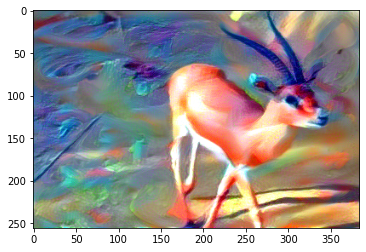

In [ ]:
plt.imshow(imgtensor2pil(input_tensor[0].cpu()));